# Local Reef Morphological Feature Fetch
This file is used to extract and calculate reef-related parameters from the bathymetry dataset. Because the used bathymetry dataset is very large, the code in this file can only process one island at a time.


**Manual Setup in Google Colab**

Some required files must be manually uploaded to Google Colab before running the code. All the necessary files can be found in the current directory's subfolder named `Model_Data`.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


The calculation of reef morphology-related features is based on the bathymetric dataset proposed by Rasheed, S., et al. in *“An improved gridded bathymetric data set and tidal model for the Maldives archipelago”* (2021), *Earth and Space Science*, 8(5): e2020EA001207.

**To run the code below, please**:
1.  Obtain the bathymetric data as described in Rasheed's paper, and then proceed with the subsequent code execution.
2.  Please go to the subfolder corresponding to the island under the **Fetch_data** directory, and upload the corresponding `shoreline_coords.csv` files to the Colab workspace.


In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import RegularGridInterpolator
from pyproj import Geod, Transformer
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
file_path = "/content/drive/My Drive/irp/data/Surface0_35s.nc"  # TODO: Please replace it with the path to your downloaded Surface0_35s.nc dataset.
ds = xr.open_dataset(file_path)
lon_bathy = ds['lon'].values
lat_bathy = ds['lat'].values
bathy = ds['z'].values

interp_bathy = RegularGridInterpolator((lat_bathy, lon_bathy), bathy, bounds_error=False, fill_value=np.nan)

In [ ]:
df_transects = pd.read_csv('./shoreline_coords.csv')

transformer = Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True)

longitudes, latitudes = [], []

for idx, row in df_transects.iterrows():
    lon_proj = row['longitude']
    lat_proj = row['latitude']
    lon, lat = transformer.transform(lon_proj, lat_proj)
    longitudes.append(lon)
    latitudes.append(lat)

df_transects['longitude'] = longitudes
df_transects['latitude'] = latitudes

geod = Geod(ellps='WGS84')
results = []


search_radius = 1000  # 1km search radius around shoreline point

In [ ]:
for idx, row in df_transects.iterrows():
    transect_id = row['transect_id']
    lon_t = row['longitude']
    lat_t = row['latitude']
    dates_t = str(row['dates'])

    # Extract local window
    lon_min, lon_max = lon_t - 0.01, lon_t + 0.01
    lat_min, lat_max = lat_t - 0.01, lat_t + 0.01

    ds_sub = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    if ds_sub['lon'].size == 0 or ds_sub['lat'].size == 0:
        continue

    lon_sub = ds_sub['lon'].values
    lat_sub = ds_sub['lat'].values
    bathy_sub = ds_sub['z'].values

    lon_grid, lat_grid = np.meshgrid(lon_sub, lat_sub, indexing='xy')
    flat_points = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T
    depths = bathy_sub.ravel()

    # Calculate distance to the shoreline point
    distances = np.array([geod.inv(lon_t, lat_t, lon_p, lat_p)[2] for lon_p, lat_p in flat_points])

    mask = distances <= search_radius
    if np.sum(mask) == 0:
        continue

    candidate_points = flat_points[mask]
    candidate_depths = depths[mask]

    # Find the shallowest point = reef crest
    idx_crest = np.nanargmax(candidate_depths)
    lon_crest, lat_crest = candidate_points[idx_crest]
    reef_crest_elev = candidate_depths[idx_crest]  # reef crest elevation (m)

    # Reef width
    _, _, reef_width = geod.inv(lon_t, lat_t, lon_crest, lat_crest)

    if reef_width == 0 or np.isnan(reef_width):
        reef_slope = np.nan
        reef_flat_depth = np.nan
    else:
        # Sample profile between shoreline and reef crest
        n_steps = 50
        lats_profile = np.linspace(lat_t, lat_crest, n_steps)
        lons_profile = np.linspace(lon_t, lon_crest, n_steps)
        profile_points = np.vstack([lats_profile, lons_profile]).T
        profile_depths = interp_bathy(profile_points)

        reef_flat_depth = np.nanmean(profile_depths)
        slope_val = (reef_crest_elev - profile_depths[0]) / reef_width
        reef_slope = np.degrees(np.arctan(slope_val))

    results.append({
        'dates': dates_t,
        'transect_id': transect_id,
        'longitude': lon_t,
        'latitude': lat_t,
        'reef_width_m': reef_width,
        'reef_slope_deg': reef_slope,
        'reef_crest_elevation_m': reef_crest_elev,
        'reef_flat_mean_depth_m': reef_flat_depth
    })

df_result = pd.DataFrame(results)
df_result.to_csv('Reef_Geomorphometrics.csv', index=False)

## Visualization

The following code is used to  prints descriptive statistics and value ranges, and creates visualizations:  
- A scatter plot of **reef width vs. slope**  
- A histogram of **reef crest elevation**  
- A histogram of **reef flat mean depth**



=== Descriptive Statistics ===

         longitude     latitude  reef_width_m  reef_slope_deg  \
count  7998.000000  7998.000000   7998.000000     7998.000000   
mean     72.995523     5.175114    253.824513        1.072871   
std       0.001322     0.001304    124.765340        0.952032   
min      72.993389     5.171918     34.160642        0.110498   
25%      72.994263     5.174028    153.788911        0.409837   
50%      72.995449     5.175117    254.245170        0.790183   
75%      72.996817     5.176270    331.465960        1.209515   
max      72.997626     5.177390    580.033199        4.557478   

       reef_crest_elevation_m  reef_flat_mean_depth_m  
count            7.998000e+03             7998.000000  
mean             1.781562e-01               -0.962877  
std              1.196340e-14                0.464781  
min              1.781562e-01               -3.271627  
25%              1.781562e-01               -1.243454  
50%              1.781562e-01               -

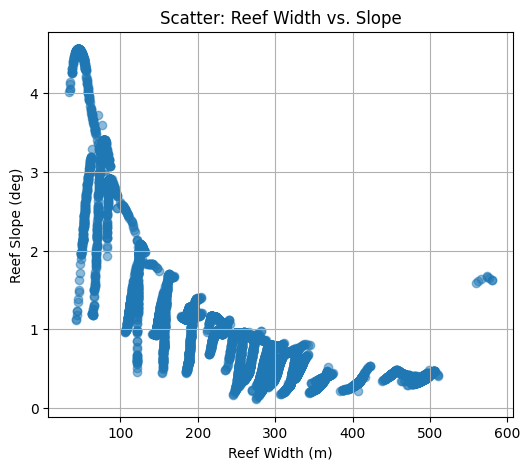

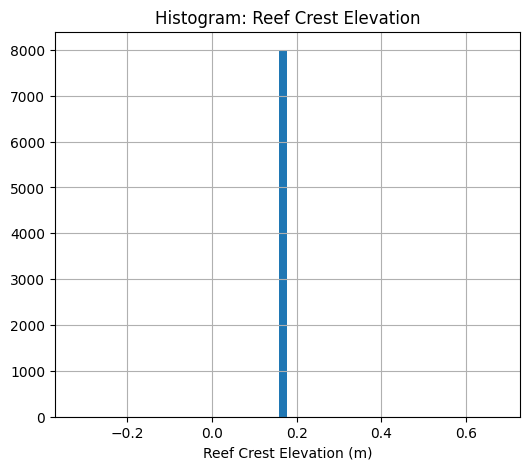

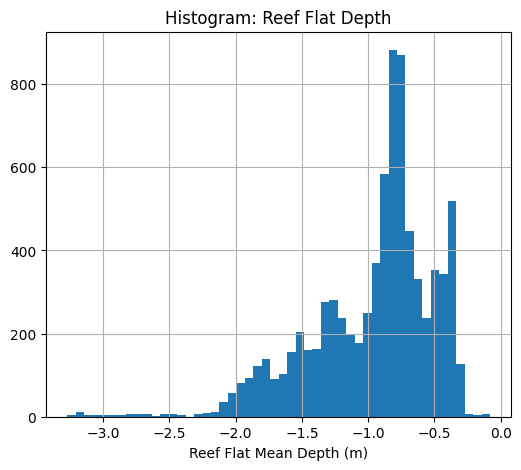

In [ ]:
df = pd.read_csv('Reef_Geomorphometrics.csv')

# Descriptive statistics summary
print("\n=== Descriptive Statistics ===\n")
print(df.describe())

# Range checks for main metrics
print("\n=== Range Checks ===\n")
print("Reef Width: min =", df['reef_width_m'].min(), "max =", df['reef_width_m'].max())
print("Reef Slope: min =", df['reef_slope_deg'].min(), "max =", df['reef_slope_deg'].max())
print("Reef Crest Elevation: min =", df['reef_crest_elevation_m'].min(), "max =", df['reef_crest_elevation_m'].max())
print("Reef Flat Mean Depth: min =", df['reef_flat_mean_depth_m'].min(), "max =", df['reef_flat_mean_depth_m'].max())

# Visualization: Width vs. Slope
plt.figure(figsize=(6, 5))
plt.scatter(df['reef_width_m'], df['reef_slope_deg'], alpha=0.5)
plt.xlabel("Reef Width (m)")
plt.ylabel("Reef Slope (deg)")
plt.title("Scatter: Reef Width vs. Slope")
plt.grid(True)
plt.show()

# Visualization: Reef crest elevation histogram
plt.figure(figsize=(6, 5))
plt.hist(df['reef_crest_elevation_m'], bins=50)
plt.xlabel("Reef Crest Elevation (m)")
plt.title("Histogram: Reef Crest Elevation")
plt.grid(True)
plt.show()

# Visualization: Reef flat depth histogram
plt.figure(figsize=(6, 5))
plt.hist(df['reef_flat_mean_depth_m'], bins=50)
plt.xlabel("Reef Flat Mean Depth (m)")
plt.title("Histogram: Reef Flat Depth")
plt.grid(True)
plt.show()
